In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
juypter_root = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
%cd $juypter_root

/home/bene/Projects/mindcraft


In [3]:
from mindcraft.torch.module import AutoEncoder
from mindcraft.torch.module import Conv
from mindcraft.torch.module import FeedForward
from mindcraft.torch.module import ConvT
from mindcraft.torch.module import VaCoEmbedding

In [4]:
def get_MNIST(batch_size, dataset_directory, dataloader_workers, source='MNIST'):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    data_source = getattr(torchvision.datasets, source)
    
    train_dataset = data_source(root=dataset_directory, train=True, download=True, transform=train_transformation)

    test_dataset =  data_source(root=dataset_directory, train=False, download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    # Prepare Data Loaders for training and validation
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                              pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, test_dataset, train_loader, test_loader

In [5]:
ENCODER_DROPOUT = 0.3
DECODER_DROPOUT = 0.2
USE_BATCHNORM = True

BATCHSIZE = 32
LEARNINGRATE = 0.005

train_dataset, test_dataset, train_loader, test_loader = get_MNIST(BATCHSIZE, 'examples/dataset', 12, 'MNIST')

In [6]:
def show_latent(data_loader=test_loader):
    y_latent = []
    y_labels = []
    for batch_features, batch_labels in data_loader:
        batch_features = batch_features.to(device)
        y = model.encode(batch_features).detach().cpu().numpy()
        y_latent.extend(y)
        y_labels.extend(batch_labels.numpy())

    y_latent = np.asarray(y_latent)
    y_labels = np.asarray(y_labels)
    
    digit_map = [y_labels == i for i in range(10)]
    
    plt.figure(figsize=(10,10))
    for i, where_i in enumerate(digit_map):
        selection = y_latent[where_i]    
        plt.scatter(*selection[...,:2].T, label=f'#{i}', alpha=0.5)
    plt.legend()
    
    return y_latent

input shape: (1, 28, 28)


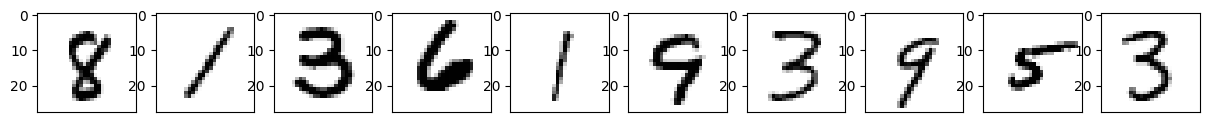

In [7]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks

input_shape = tuple(train_dataset[0][0].shape)
print('input shape:', input_shape)

In [8]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.randn(2, *input_shape)
x_random = x_random.to(device)

GPU available


In [9]:
encoder = Conv(
    input_size=1,
    input_dim=2,
    kernel_size=(3, 3, 3, 3, 1),
    filters=(8, 16, 32, 128, 2),
    strides=(2, 2, 2, 1, 1),
    padding=(1, 1, 0, 0, 0),
    flatten=True,
    activation=['ELU', 'ELU', 'ELU', 'ELU', None],
    dropout=[ENCODER_DROPOUT, ENCODER_DROPOUT, ENCODER_DROPOUT, ENCODER_DROPOUT, None],
    batch_norm=USE_BATCHNORM
)

encoder = encoder.to(device)
print(encoder.parameters_str)

x = torch.randn(10, 1, 28, 28).to(device)
print("Tensor", tuple(x.shape))
for layer in encoder.cnn:
    if any(s in layer.__class__.__name__ for s in ["Batch", "ReLU", "Drop"]):
        continue
    x = layer(x)    
    print(layer.__class__.__name__, tuple(x.shape))

Conv
cnn.0.weight	(8, 1, 3, 3)
cnn.0.bias	(8,)
cnn.1.weight	(8,)
cnn.1.bias	(8,)
cnn.4.weight	(16, 8, 3, 3)
cnn.4.bias	(16,)
cnn.5.weight	(16,)
cnn.5.bias	(16,)
cnn.8.weight	(32, 16, 3, 3)
cnn.8.bias	(32,)
cnn.9.weight	(32,)
cnn.9.bias	(32,)
cnn.12.weight	(128, 32, 3, 3)
cnn.12.bias	(128,)
cnn.13.weight	(128,)
cnn.13.bias	(128,)
cnn.16.weight	(2, 128, 1, 1)
cnn.16.bias	(2,)
cnn.17.weight	(2,)
cnn.17.bias	(2,)
num-params    : 43510
num-trainables: 43510

Tensor (10, 1, 28, 28)
Conv2d (10, 8, 14, 14)
ELU (10, 8, 14, 14)
Conv2d (10, 16, 7, 7)
ELU (10, 16, 7, 7)
Conv2d (10, 32, 3, 3)
ELU (10, 32, 3, 3)
Conv2d (10, 128, 1, 1)
ELU (10, 128, 1, 1)
Conv2d (10, 2, 1, 1)
Flatten (10, 2)


In [10]:
decoder = ConvT(
    input_size=2,
    input_dim=2,
    filters=[128, 32, 16, 8, 1],
    kernel_size=[1, 3, 3, 3, 3],
    strides=[1, 1, 2, 2, 2],
    padding=(0, 0, 0, 1, 1),
    output_padding=(0, 0, 0, 1, 1),
    activation=['ELU', 'ELU', 'ELU', 'ELU', 'Sigmoid'],
    dropout=[DECODER_DROPOUT, DECODER_DROPOUT, DECODER_DROPOUT, DECODER_DROPOUT, None],
    batch_norm=USE_BATCHNORM
)

decoder = decoder.to('cuda')
print(decoder.parameters_str)

x = torch.randn(10, 2, 1, 1).to(device)
print("Tensor         ", tuple(x.shape))
for layer in decoder.cnn_t:
    if any(s in layer.__class__.__name__ for s in ["Batch", "ReLU", "Sig", "Tanh", "Drop"]):
        continue
    x = layer(x)    
    print(layer.__class__.__name__, tuple(x.shape))

ConvT
cnn_t.0.weight	(2, 128, 1, 1)
cnn_t.0.bias	(128,)
cnn_t.1.weight	(128,)
cnn_t.1.bias	(128,)
cnn_t.4.weight	(128, 32, 3, 3)
cnn_t.4.bias	(32,)
cnn_t.5.weight	(32,)
cnn_t.5.bias	(32,)
cnn_t.8.weight	(32, 16, 3, 3)
cnn_t.8.bias	(16,)
cnn_t.9.weight	(16,)
cnn_t.9.bias	(16,)
cnn_t.12.weight	(16, 8, 3, 3)
cnn_t.12.bias	(8,)
cnn_t.13.weight	(8,)
cnn_t.13.bias	(8,)
cnn_t.16.weight	(8, 1, 3, 3)
cnn_t.16.bias	(1,)
cnn_t.17.weight	(1,)
cnn_t.17.bias	(1,)
num-params    : 43507
num-trainables: 43507

Tensor          (10, 2, 1, 1)
ConvTranspose2d (10, 128, 1, 1)
ELU (10, 128, 1, 1)
ConvTranspose2d (10, 32, 3, 3)
ELU (10, 32, 3, 3)
ConvTranspose2d (10, 16, 7, 7)
ELU (10, 16, 7, 7)
ConvTranspose2d (10, 8, 14, 14)
ELU (10, 8, 14, 14)
ConvTranspose2d (10, 1, 28, 28)


In [11]:
model = AutoEncoder(encoder=encoder, decoder=decoder)
model = model.to(device)

print("Encoding:", x_random.shape, "->", model.encode(x_random).shape)
print("Decoding:", model.encode(x_random).shape, "->", model.decode(model.encode(x_random)).shape)

Encoding: torch.Size([2, 1, 28, 28]) -> torch.Size([2, 2])
Decoding: torch.Size([2, 2]) -> torch.Size([2, 1, 28, 28])


In [12]:
expand = FeedForward(input_size=2, hidden_size=[8, 16], output_size=32, activation=["GELU", "GELU", None])
vaco_embedding = VaCoEmbedding(expand=expand, var_loss=0.1, cov_loss=0.01)
vaco_embedding = vaco_embedding.to(device)


print("Embedding:", 
      x_random.shape, "->",
      model.encode(x_random).shape, "->", 
      vaco_embedding(model.encode(x_random), embedding=True).shape)

Embedding: torch.Size([2, 1, 28, 28]) -> torch.Size([2, 2]) -> torch.Size([2, 32])


10000 datapoints


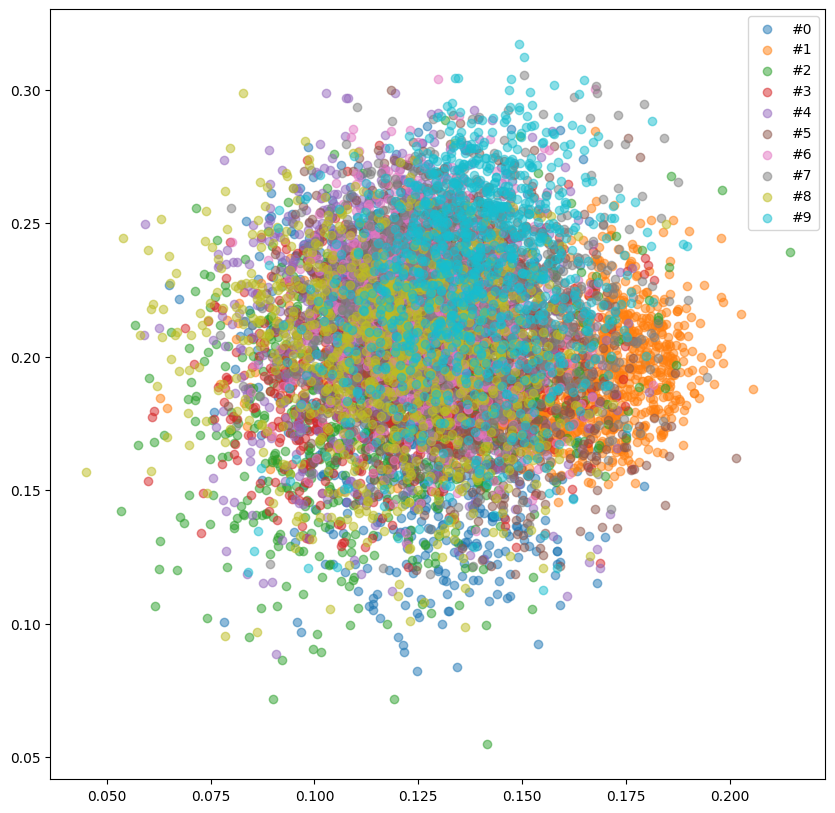

In [13]:
model.eval()
latent_space = show_latent()
print(f'{len(latent_space)} datapoints')

In [46]:
BATCHSIZE = 32
LEARNINGRATE = 0.001

EPOCHS = 150
WINDOW = 5
STOPPING = 1e-3

N_BATCHSIZE_UPDATES = 5

In [47]:
# create an optimizer object
model_params = list(model.parameters()) + list(vaco_embedding.parameters())
optimizer = torch.optim.Adam(model_params,     # link model parameters
                             lr=LEARNINGRATE)  # set learning rate

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [48]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]}]


In [17]:
loss_history = []
var_loss_history = []
cov_loss_history = []
r_loss_history = []
valid_history = []
variations = []

In [ ]:
batchsize_updates = 0
batchsize_update_rate=1.125
model.train()

for epoch in range(EPOCHS):
    loss, r_loss, var_loss, cov_loss = 0, 0, 0, 0

    for batch in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch = [b.to(device) for b in batch]
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # TRAINING STEP: x -> (mu, std) -> (q -> z) -> x_hat
        ae_r_loss, encodings = model.batch_loss(batch, return_encodings=True)
        vaco_var_loss, vaco_cov_loss = vaco_embedding.loss(encodings)

        # compute accumulated gradients
        elbo_loss = ae_r_loss + vaco_var_loss + vaco_cov_loss
        elbo_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        scheduler.step()

        # add the mini-batch training loss to epoch loss
        loss += elbo_loss.item()
        r_loss += ae_r_loss.item()
        var_loss += vaco_var_loss.item()
        cov_loss += vaco_cov_loss.item()
    
    valid = 0
    for test_batch in test_loader:
        test_batch = [b.to(device) for b in test_batch]
        test_loss, encodings = model.batch_loss(test_batch, return_encodings=True)
        test_var_loss, test_cov_loss = vaco_embedding.loss(encodings)
        valid += (test_loss + test_var_loss + test_cov_loss).item()
    
    # compute the epoch training loss
    loss_history.append(loss / len(train_loader))
    r_loss_history.append(r_loss / len(train_loader))
    var_loss_history.append(var_loss / len(train_loader))                        
    cov_loss_history.append(cov_loss / len(train_loader))                        
    valid_history.append(valid / len(test_loader))
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f} (VAR: {:.6f}, COV: {:.6f}, RECON.: {:.6f}), valid = {:.6f}".format(
        epoch + 1, EPOCHS, loss_history[-1], var_loss_history[-1],cov_loss_history[-1], r_loss_history[-1], valid_history[-1],
    ))
    
    
    if epoch > 0 and epoch % 10 == 0:
        if batchsize_updates < N_BATCHSIZE_UPDATES:
            batchsize_updates += 1
            BATCHSIZE = int(batchsize_update_rate * BATCHSIZE)
            train_dataset, test_dataset, train_loader, test_loader = get_MNIST(
                BATCHSIZE, 'examples/dataset/', 12, 'MNIST')
            print(f"update batchsize to {BATCHSIZE}")
            
        

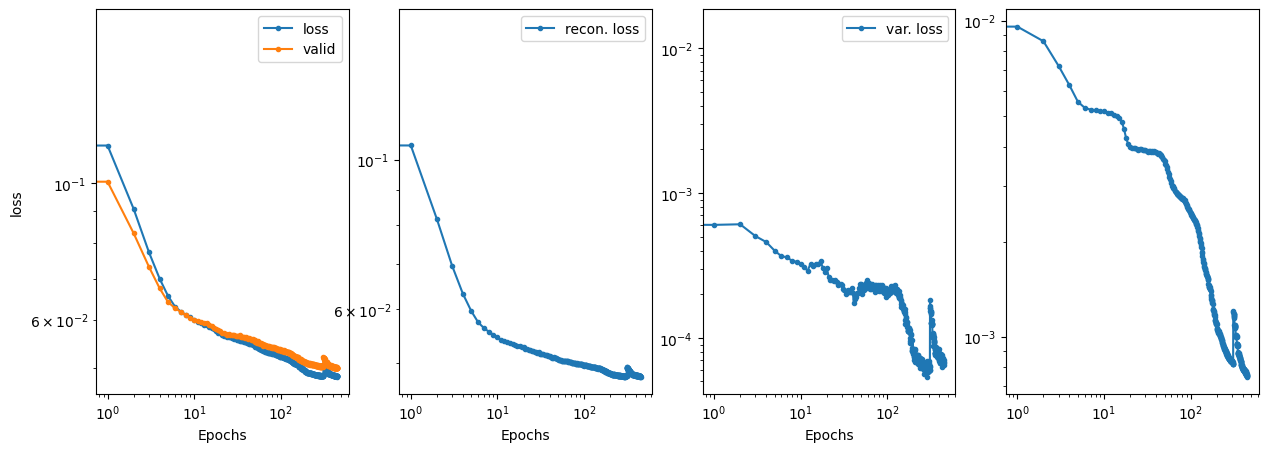

In [42]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

ax1.loglog(loss_history, marker='.', label='loss')
ax1.loglog(valid_history, marker='.', label='valid')
ax2.loglog(np.asarray(r_loss_history), marker='.', label='recon. loss')
ax3.loglog(np.asarray(var_loss_history), marker='.', label='var. loss')
ax4.loglog(np.asarray(cov_loss_history), marker='.', label='cov. loss')
ax1.set_ylabel('loss')
[axi.set_xlabel('Epochs') for axi in [ax1, ax2, ax3]]
[axi.legend() for axi in [ax1, ax2, ax3]];

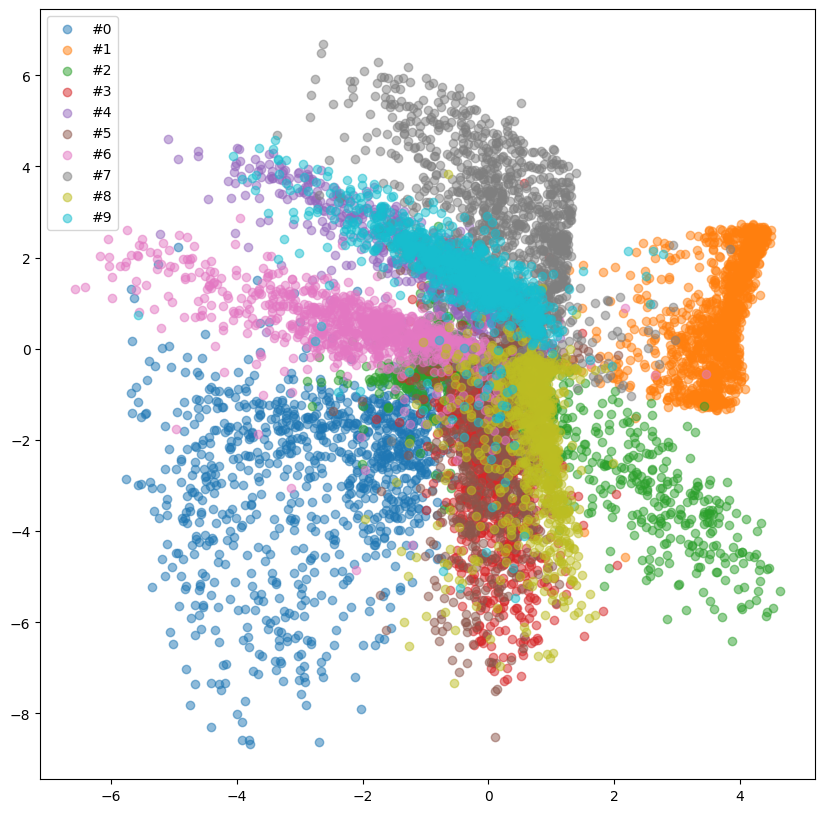

In [33]:
model.eval()
y_latent = show_latent()

In [34]:
y_latent_range = list({'min': li.min(), 'mean': li.mean(), 'max': li.max()} for li in y_latent.T)
y_latent_range

[{'min': -6.5650153, 'mean': -0.016147885, 'max': 4.63567},
 {'min': -8.676257, 'mean': -0.29052678, 'max': 6.681449}]

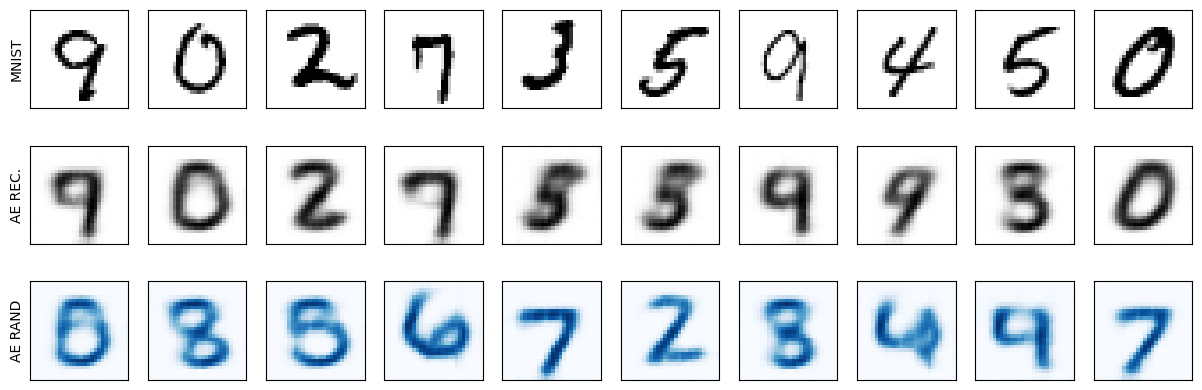

In [35]:
n = 10

z_rand = np.random.rand(n, 2)
for i in range(z_rand.shape[-1]):
    range_i = (y_latent_range[i]['max'] - y_latent_range[i]['min'])
    offset_i = 0.5 - y_latent_range[i]['mean'] / range_i
    z_rand[..., i] -= offset_i
    z_rand[..., i] *= range_i
    
t_rand = torch.from_numpy(z_rand).float().to(device)
y_rand = model.decoder(t_rand)
y_numpy = y_rand.detach().cpu().numpy()

f, axes = plt.subplots(3, n, figsize=(15, 5))
tensor_choice = [np.random.randint(len(train_dataset)) for __ in range(n)]

my_subset = torch.utils.data.Subset(train_dataset, tensor_choice)
loader = torch.utils.data.DataLoader(my_subset, batch_size=len(tensor_choice))
for tensors, __ in loader:
    reconst = model(tensors.to(device))

    for i, ax in enumerate(axes.T):
        ax[0].imshow(tensors[i].detach().numpy().transpose(1,2,0), cmap='binary')
        ax[1].imshow(reconst[i].detach().cpu().numpy().transpose(1,2,0), cmap='binary')

        ax[2].imshow(y_numpy[i].transpose(1,2,0), cmap='Blues')
        ax[0].set_xticks([]); ax[0].set_yticks([])
        ax[1].set_xticks([]); ax[1].set_yticks([])
        ax[2].set_xticks([]); ax[2].set_yticks([])

    axes[0][0].set_ylabel('MNIST');
    axes[1][0].set_ylabel('AE REC.');
    axes[2][0].set_ylabel('AE RAND');

In [36]:
from mindcraft.torch.util import tensor_to_numpy

offset = 15
encodings = []

for i, (batch_features, __) in enumerate(test_loader):
    latent = model.encode(batch_features.to(device))
    encodings.append(tensor_to_numpy(latent))
        
encodings = np.concatenate(encodings, axis=0)

## Latent Space Distros

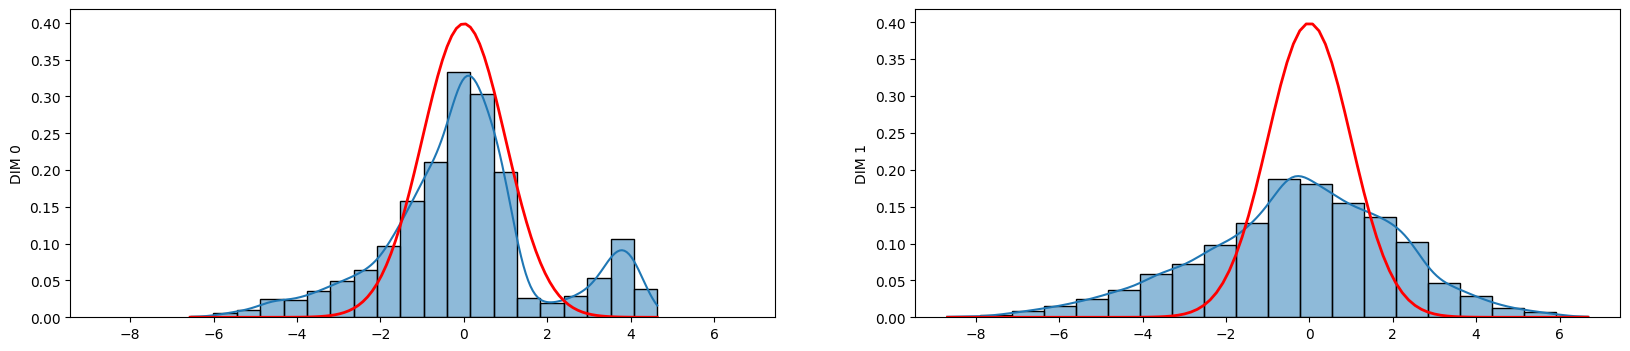

In [37]:
h_split = 2
f, axes = plt.subplots(int(2//h_split), h_split, figsize=(20, 4), sharex=True)

dim = 0
for cols in axes:
    for ax in cols if hasattr(cols, '__iter__') else [cols]:
               
        # show data distribution
        sns.histplot(encodings[:, dim], bins=20, ax=ax, kde=True, stat='density')
        
        # calculate the pdf over a range of values
        xx = np.linspace(min(encodings[:, dim]), max(encodings[:, dim]), 101)
        yy = stats.norm.pdf(xx)                                                         
        
        # and plot on the same axes that seaborn put the histogram
        ax.plot(xx, yy, 'r', lw=2)   
        ax.set_ylabel(f"DIM {dim}")
        
        dim += 1

In [29]:
class LatentExplorer():
    def __init__(self, z_size, model, z_dim=0, x0=None):
        self.z_dim = z_dim
        self.z_size = z_size
        self.z_value = self.randomize()
        self._randomize = False
        self.model = model
    
    def randomize(self):
        return np.random.randn(self.z_size)

    def explore(self):                      
        @interact
        def decode(z_dim=['0', '1'], value=(-3., 3., 0.1), randomize=self._randomize, true_colors=False):
            hue = ['tab:blue'] * self.z_size
            fig = plt.figure(figsize=(15, 3))
            ax1 = plt.subplot2grid((1,4), (0, 0))
            ax2 = plt.subplot2grid((1,4), (0, 1), colspan=3)
                        
            try:
                if randomize != self._randomize:
                    self.z_value = self.randomize()
                    self._randomize = randomize
                    
                i = int(z_dim)
                self.z_value[i] = value
                hue[i] = 'tab:orange'
                
                x_hat = self.model.decode(torch.Tensor(self.z_value[None,...]).to(device))
                x_hat = tensor_to_numpy(x_hat)[0].transpose((1,2,0))
                if true_colors:
                    x_hat = 1 - x_hat

                plt.figure(figsize=(3, 3))
                ax1.imshow(x_hat)        
                
            except:
                raise
                
            
            x = np.arange(0, self.z_size, 1)
            y = self.z_value
            
            ax2.bar(x, y, color=hue)
            ax2.set_ylim([-3, 3])
            ax2.grid()
            print('z:', self.z_value)
            plt.show()
    

# LatentExplorer(z_size=2, model=model).explore()

In [30]:
LatentExplorer(2, model).explore()

interactive(children=(Dropdown(description='z_dim', options=('0', '1'), value='0'), FloatSlider(value=0.0, des…